In [89]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import json

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

In [ ]:
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

ts = pd.read_csv(data_path)
ts = ts["Close"].values

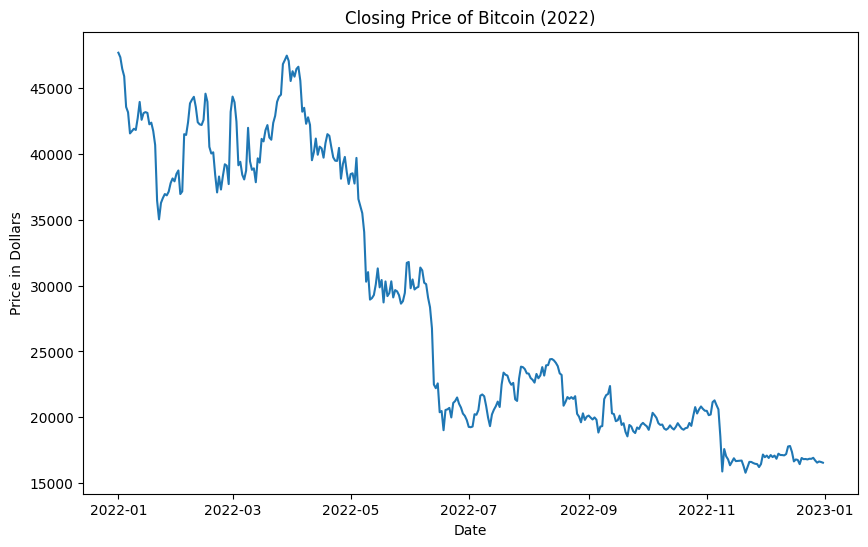

In [15]:
start_date = '2022-01-01'
end_date = '2022-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

plt.figure(figsize=(10, 6))
plt.plot(date_range, ts)
plt.title('Closing Price of Bitcoin (2022)')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')
plt.show()

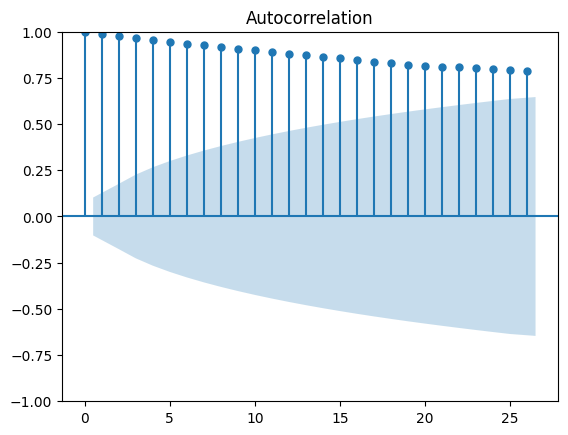

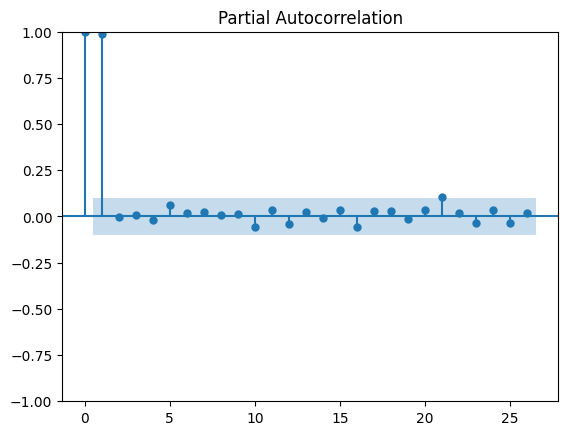

In [17]:
plot_acf(ts)
plt.show()

plot_pacf(ts)
plt.show()

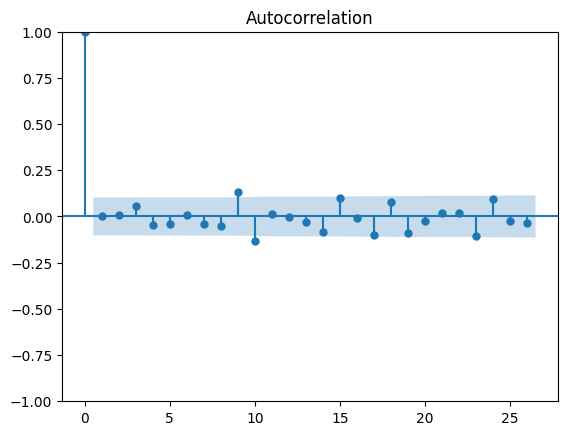

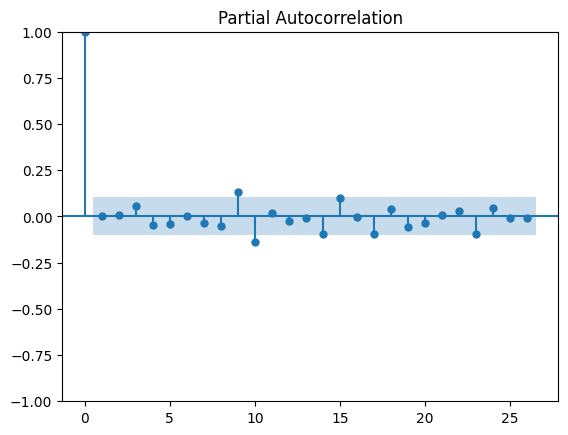

In [23]:
diff = np.diff(ts)

plot_acf(diff)
plt.show()

plot_pacf(diff)
plt.show()

In [24]:
unit_test = adfuller(diff)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")

ADF Statistic: -6.511663
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.4489583388155194), '5%': np.float64(-2.869739378430086), '10%': np.float64(-2.5711381780459)}
Reject the null hypothesis. The time-series is stationary.


In [25]:
# train-validation-test split for time series
train_size = int(len(ts) * 0.70)
train, rest = ts[:train_size], ts[train_size:]

validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

255
55
55


In [27]:
lowest_aic = float('inf')
best_p_aic = None
best_q_aic = None

lowest_bic = float('inf')
best_p_bic = None
best_q_bic = None

for p in range(0,10):
    for q in range(0,10):
        #create model
        model=ARIMA(train, order=(p,1,q))
        results = model.fit()

        #AIC and BIC of model
        aic = results.aic
        bic = results.bic
        print(f"AR({p}), MA({q}), AIC: {aic}, BIC: {bic}")

        #Update the best order based on the lowest AIC
        if aic < lowest_aic:
            lowest_aic = aic
            best_p_aic = p
            best_q_aic = q
        
        #Update the best order based on the lowest BIC
        if bic < lowest_bic:
            lowest_bic = bic
            best_p_bic = p
            best_q_bic = q

print(f"\nBest ARIMA order based on AIC: ({best_p_aic},0,{best_q_aic}) \nBest ARIMA order based on BIC: ({best_p_bic},0,{best_q_bic})")

AR(0), MA(0), AIC: 4308.818418459345, BIC: 4312.355752726363
AR(0), MA(1), AIC: 4310.803344628967, BIC: 4317.878013163005
AR(0), MA(2), AIC: 4312.582955478284, BIC: 4323.1949582793395
AR(0), MA(3), AIC: 4314.543914370507, BIC: 4328.693251438581
AR(0), MA(4), AIC: 4312.793480790293, BIC: 4330.480152125386
AR(0), MA(5), AIC: 4314.473800275959, BIC: 4335.69780587807
AR(0), MA(6), AIC: 4315.183458348754, BIC: 4339.944798217884
AR(0), MA(7), AIC: 4317.1841683503335, BIC: 4345.482842486482
AR(0), MA(8), AIC: 4318.819475717366, BIC: 4350.6554841205325
AR(0), MA(9), AIC: 4318.8396647545305, BIC: 4354.213007424716
AR(1), MA(0), AIC: 4310.80356557217, BIC: 4317.878234106207
AR(1), MA(1), AIC: 4312.8100688094255, BIC: 4323.422071610481
AR(1), MA(2), AIC: 4309.671561545709, BIC: 4323.820898613783
AR(1), MA(3), AIC: 4311.428335514823, BIC: 4329.1150068499155
AR(1), MA(4), AIC: 4312.733212391954, BIC: 4333.957217994065
AR(1), MA(5), AIC: 4313.4176956712545, BIC: 4338.179035540385
AR(1), MA(6), AIC: 

In [40]:
model = ARIMA(train, order=(best_p_aic,1,best_q_aic))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  255
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -2147.662
Date:                Tue, 10 Dec 2024   AIC                           4307.325
Time:                        11:59:20   BIC                           4328.549
Sample:                             0   HQIC                          4315.863
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9230      0.028    -67.783      0.000      -1.979      -1.867
ar.L2         -0.9249      0.028    -32.806      0.000      -0.980      -0.870
ma.L1          1.9554      0.077     25.526      0.0

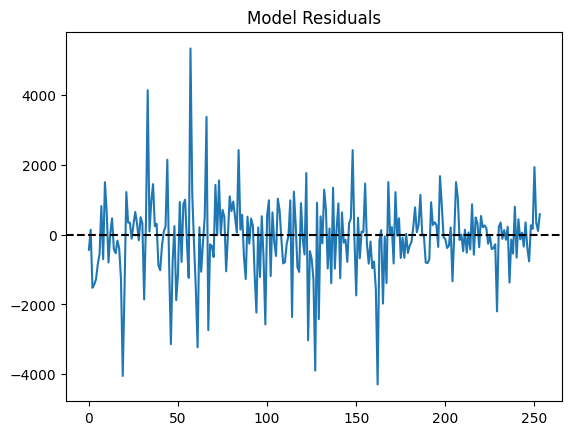

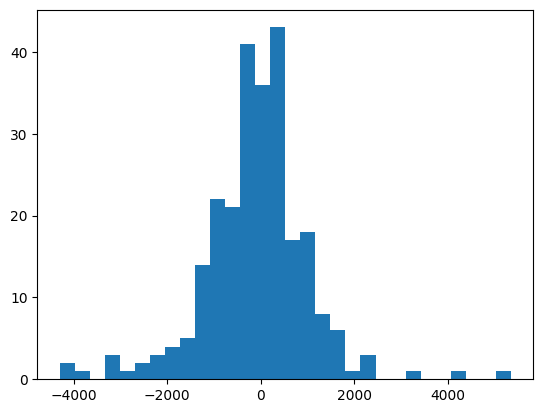

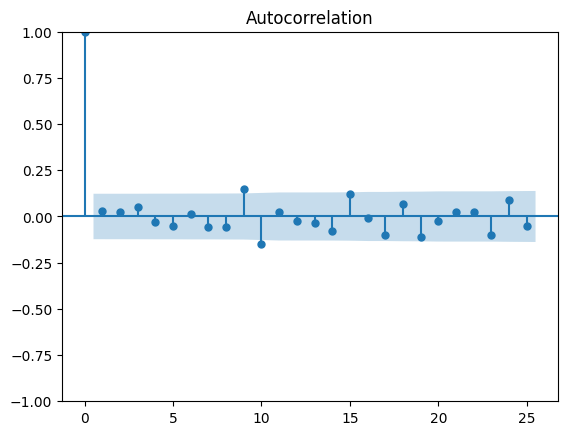

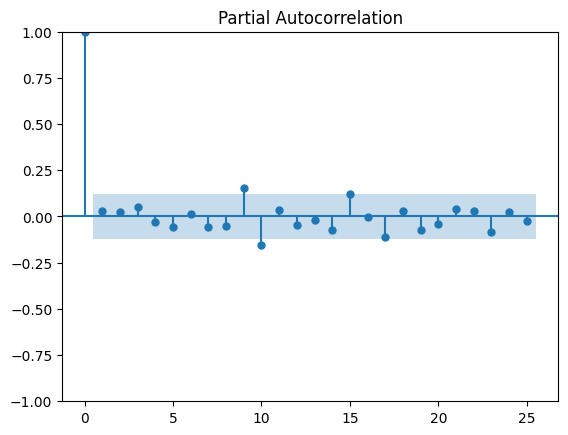

Mean of the residuals: -98.58659092742455

Results from Breusch-Godfrey Test
Test-Statistic: 0.8703481605448216
P-Value: 0.9999934942826594
Fail to reject the null hypothesis. Evidence does not suggest serial correlation.


In [57]:
# plot residuals
residuals = results.resid[1:]
plt.plot(residuals)
plt.axhline(y=0, c="black", linestyle="--")
plt.title("Model Residuals")
plt.show()

# histogram of the residuals
plt.hist(residuals, bins=30)
plt.show()

# plot acf and pacf of the residuals
plot_acf(residuals)
plt.show()
plot_pacf(residuals)
plt.show()

# summary stats of residuals
print(f'Mean of the residuals: {np.mean(residuals)}')

# BG test for serial correlation
lagrange_t_stat, p_value, _, _ = acorr_breusch_godfrey(results, nlags=12)
print(f"\nResults from Breusch-Godfrey Test\nTest-Statistic: {lagrange_t_stat}\nP-Value: {p_value}")

if p_value <= 0.05:
    print(f"Reject the null hypothesis. Presence of serial correlation in the residuals is likely.")
else: 
    print(f"Fail to reject the null hypothesis. Evidence does not suggest serial correlation.")


In [47]:
fitted = results.fittedvalues[1:] #remove the first value due to differencing in ARIMA

mse = mean_squared_error(train[1:], fitted)
rmse = sqrt(mse)
print(f"Train RMSE: {rmse}")

Train RMSE: 1137.5035945158836


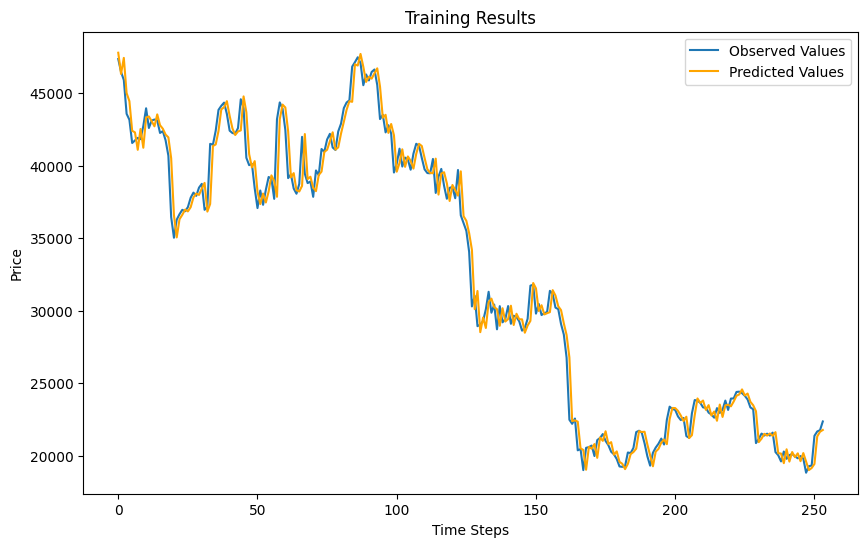

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(train[1:], label='Observed Values')
plt.plot(fitted, c='orange', label="Predicted Values")
plt.title("Training Results")
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

## Validation

In [82]:
def validiation_process(validation_set):
    '''
    Selects the most optimal model parameters based on RMSE on the validation set. 

    Input: validation set
    Output: optimal p, optimal q, rmse, predictions
    '''

    #These are the values to be returned by this function
    best_p = None
    best_q = None
    lowest_rmse = float('inf')
    predictions = []

    #Run through each possible p and q in our selected range
    for p in range(0,9):
        for q in range(0,9):
            try:
                history = list(validation_set) #reset history
                temp_predictions = [] 

                #Run through each valdiation set observation
                for i in range(len(validation_set+1)):
                    model = ARIMA(history, order=(p,1,q))
                    results = model.fit()
                    
                    #One-step-ahead forecast
                    yhat = results.forecast()
                    yhat = yhat[0]

                    #Append history with latest observation and update predictions with latest prediction
                    obs = validation_set[i]
                    history.append(obs)
                    temp_predictions.append(yhat)
                    # predictions[f'ARIMA({p},1,{q}) Predictions'].append(yhat)

                #Calculate RMSE for the predictions 
                valid_mse = mean_squared_error(validation_set, temp_predictions)
                valid_rmse = sqrt(valid_mse)
                print(f"Validation RMSE for ARIMA({p},1,{q}): {valid_rmse}")

                #Update optimal ARMA model based on RMSE and update its predictions
                if valid_rmse < lowest_rmse:
                    best_p = p
                    best_q = q
                    lowest_rmse = valid_rmse
                    predictions = temp_predictions
                    print(f"New best p and q: {best_p}, {best_q}")

            except Exception as e:
                print(f'Skipped ARIMA({p},1,{q}) due to: {e}')
            
    return best_p, best_q, lowest_rmse, predictions

best_p_valid, best_q_valid, lowest_rmse_valid, valid_predictions = validiation_process(validation)

Validation RMSE for ARIMA(0,1,0): 369.7800391946432
New best p and q: 0, 0
Validation RMSE for ARIMA(0,1,1): 372.6861716353391
Validation RMSE for ARIMA(0,1,2): 359.5319158502264
New best p and q: 0, 2
Validation RMSE for ARIMA(0,1,3): 361.1234086865088
Validation RMSE for ARIMA(0,1,4): 361.609392797465
Validation RMSE for ARIMA(0,1,5): 375.9936104307678
Validation RMSE for ARIMA(0,1,6): 379.11434429681
Validation RMSE for ARIMA(0,1,7): 384.0862951894135
Validation RMSE for ARIMA(0,1,8): 372.26012531770397
Validation RMSE for ARIMA(1,1,0): 371.3498039168105
Validation RMSE for ARIMA(1,1,1): 366.8822758227079
Validation RMSE for ARIMA(1,1,2): 363.61268088285243
Validation RMSE for ARIMA(1,1,3): 358.9051773914312
New best p and q: 1, 3
Validation RMSE for ARIMA(1,1,4): 364.05496683420716
Validation RMSE for ARIMA(1,1,5): 377.07762074685894
Validation RMSE for ARIMA(1,1,6): 378.4172240029089
Validation RMSE for ARIMA(1,1,7): 377.4709883560426
Validation RMSE for ARIMA(1,1,8): 372.38096748

Optimal ARIMA Model: ARIMA(6,1,2)
Validation RMSE: 356.0083987822205


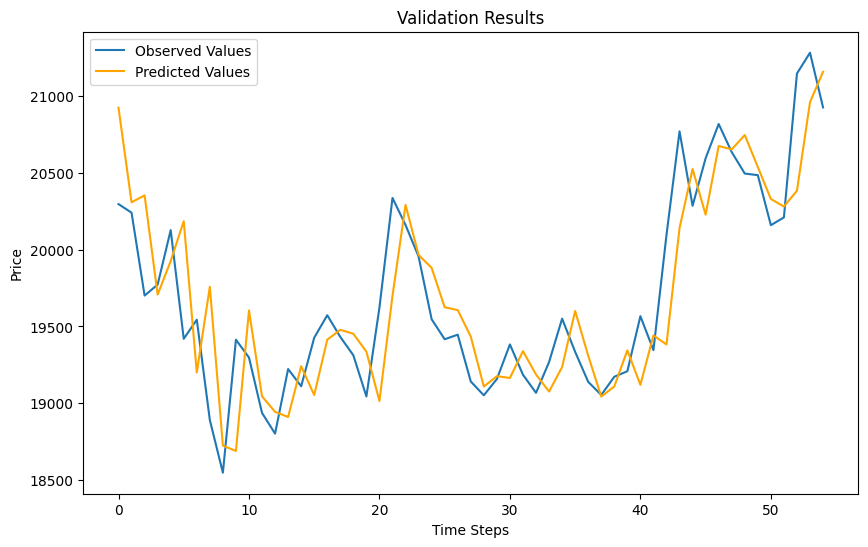

In [86]:
print(f'Optimal ARIMA Model: ARIMA({best_p_valid},1,{best_q_valid})')
print(f'Validation RMSE: {lowest_rmse_valid}')

plt.figure(figsize=(10, 6))
plt.plot(validation, label='Observed Values')
plt.plot(valid_predictions, c='orange', label="Predicted Values")
plt.title("Validation Results")
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

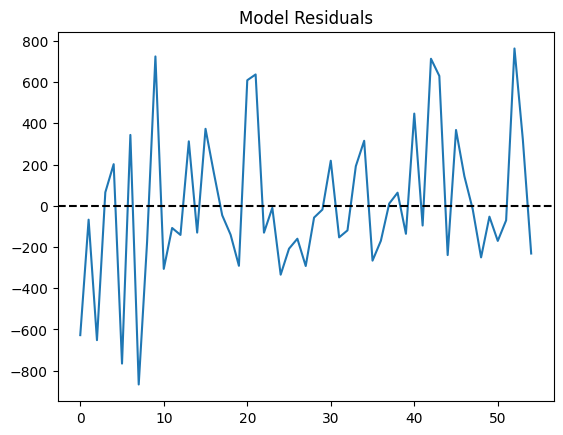

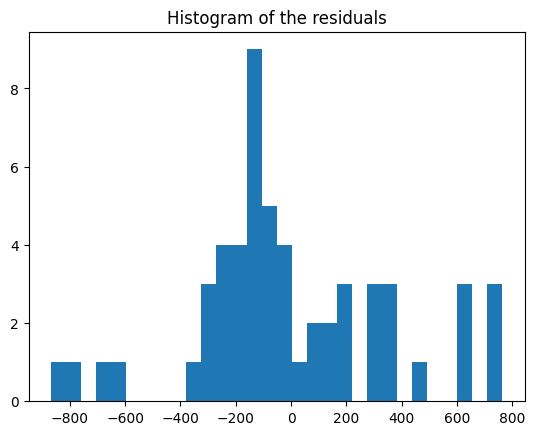

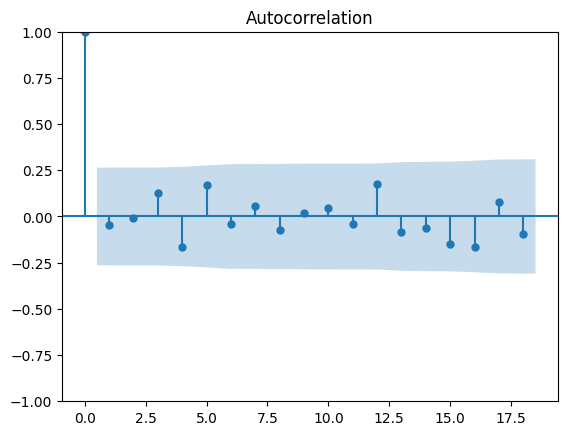

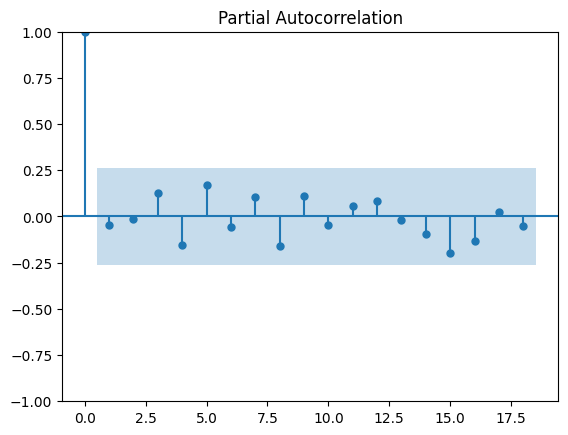

Mean of the residuals: 1.8208946242833257

Ljung-box-test results:
     lb_stat  lb_pvalue
1   0.129550   0.718899
2   0.134308   0.935051
3   1.090227   0.779434
4   2.777948   0.595645
5   4.621696   0.463768
6   4.735942   0.578099
7   4.931630   0.668307
8   5.295122   0.725617
9   5.321863   0.805397
10  5.478552   0.857008


In [94]:
# plot residuals
residuals_valid = validation - valid_predictions
plt.plot(residuals)
plt.axhline(y=0, c="black", linestyle="--")
plt.title("Model Residuals")
plt.show()

# histogram of the residuals
plt.hist(residuals_valid, bins=30)
plt.title('Histogram of the residuals')
plt.show()

# plot acf and pacf of the residuals
plot_acf(residuals_valid)
plt.show()
plot_pacf(residuals_valid)
plt.show()

# summary stats of residuals
print(f'Mean of the residuals: {np.mean(residuals_valid)}\n')

# Further statistical testing
def ljung_box_test(residuals, lags=10):
    test_results = acorr_ljungbox(residuals, lags=lags, return_df=True)
    print(f'Ljung-box-test results:\n{test_results}')
ljung_box_test(residuals)
